In [ ]:
from mean_reversion_algo import MeanReversionAlgo
%load_ext autoreload
%autoreload 2

### Trading Algorithm 

We define our strategy as an intraday mean-reversion. We look for "biggest loss days" and "biggest win days". 
We want to probe at an answer to the question: what happened the following day? 

In so far as yesterday's losers gain today, or vice versa, this should be more actionable. We can always look up who was yesterday's biggest loser. We don't need any further info. Does this alone give us an edge? 

What if we condition on winners/losers above a certain threshold? What if we condition on the index being overal up/down? Find out! 

We allow the opportunity to import data from the 1) Dow-Jones index, 2) the Nasdaq and 3) the Nifty50. 

## How do you use the algorithm? (simple case) 
index_algo = MeanReversionAlgo(index='dow')
index_algo.run()

#### Pure plot without conditions
index_algo.plot_results()

#### Conditional plot based on index performance up
index_algo.plot_results(index_condition='up')

#### Conditional plot based on winners, up more than 5%, on days when the index was down
index_algo.plot_results(index_condition='down', category_condition={'type': 'winner', 'thresholds': (5, None)})

#### Conditional correlation winners, up more than 30%, on days when the index was up
index_algo.calculate_segmented_correlation(index_condition='up', category_condition={'type': 'winner', 'thresholds': (30, None)})

## Let's look at the Dow in the period from Jan20 up until last week. 

In [ ]:
dow = MeanReversionAlgo(index='dow', start_date="01/01/2020", end_date="22/03/2024")
dow.run()

## Let's check out what happens if we control for index-overall, and whether you're a winner/loser

In [ ]:
dow.plot_results(index_condition='up', category_condition={'type': 'winner', 'thresholds': (5, None)})

In [ ]:
dow.plot_results(index_condition='down', category_condition={'type': 'loser', 'thresholds': (5, None)})

## Now let's turn to Nifty 50 

In [ ]:
nifty = MeanReversionAlgo(index='nifty50', start_date="01/01/2020", end_date="22/03/2024")
nifty.run()

In [ ]:
nifty.plot_results(index_condition='down', category_condition={'type': 'loser', 'thresholds': (7, None)})

## Finally, let's do Nasdaq (be warned ... 
... dataset larger, so this will take a while  

In [ ]:
nasdaq = MeanReversionAlgo(index='nasdaq', start_date="01/01/2020", end_date="22/03/2024")
nasdaq.run()

In [ ]:
nasdaq.plot_results(index_condition='up', category_condition={'type': 'winner', 'thresholds': (30, None)})

In [ ]:
nasdaq.calculate_segmented_correlation(index_condition='up', category_condition={'type': 'winner', 'thresholds': (30, None)})

Know lets apply this for two individual stocks Alphabet Class A and Cooper-Standard Holdings. The reasoning behind this move is to demonstrate that our theory for the market also can be applied for a higher correlated stock to the stock market (GOOGL) and a less correlated stock (CPS). Note that there is a difference in their volatility, but we disregard this.

We will now see what happend the next day after the stocks fell -5% or more, and calculate the likelihood of a next day increase.
This can to some degree validate if our strategy works on individual stock names. If the likelihood is greater than 50% for an increase, then there is a probability that our strategy is profitable. 

In [ ]:
import stock_analysis as sa

aligned_next_day_returns, likelihood_increase = sa.analyze_stock_return('GOOGL', '2015-01-01')

print(f"The likelihood of an increase after a -5% drop is: {likelihood_increase:.2%}")
sa.plot_return_series(aligned_next_day_returns)


In [ ]:
import stock_analysis as sa

aligned_next_day_returns, likelihood_increase = sa.analyze_stock_return('CPS', '2015-01-01')

print(f"The likelihood of an increase after a -5% drop is: {likelihood_increase:.2%}")

sa.plot_return_series(aligned_next_day_returns)


We see that the probability decreases by 5,25%-points which is a sign that our strategy becomes less efficient when the correlation to the market decreases. In conclusion the strategy is more efficient with larger names, but still profitable.

It should be noted that the larger drawdowns and increases are partly driven by the semiconducter shortages in relation to CPS. 

Now lets backtest it investing in Alphabet, but control our risk by using the theory of fractional kelly. 
Little background story: Kelly Fractional is often used in black jack but can be used to manage risk in the stock market. The point of it is that each time our strategy results in a profit, the next investment will be more aggressive. On the other hand when a trade results in a loss it lowers the next trade. 

Our criteria:
Initial capital: 100.000 
Initial position size: 1%
Maximum position size: 5%
Kelly Fractional: 50%

[*********************100%%**********************]  1 of 1 completed


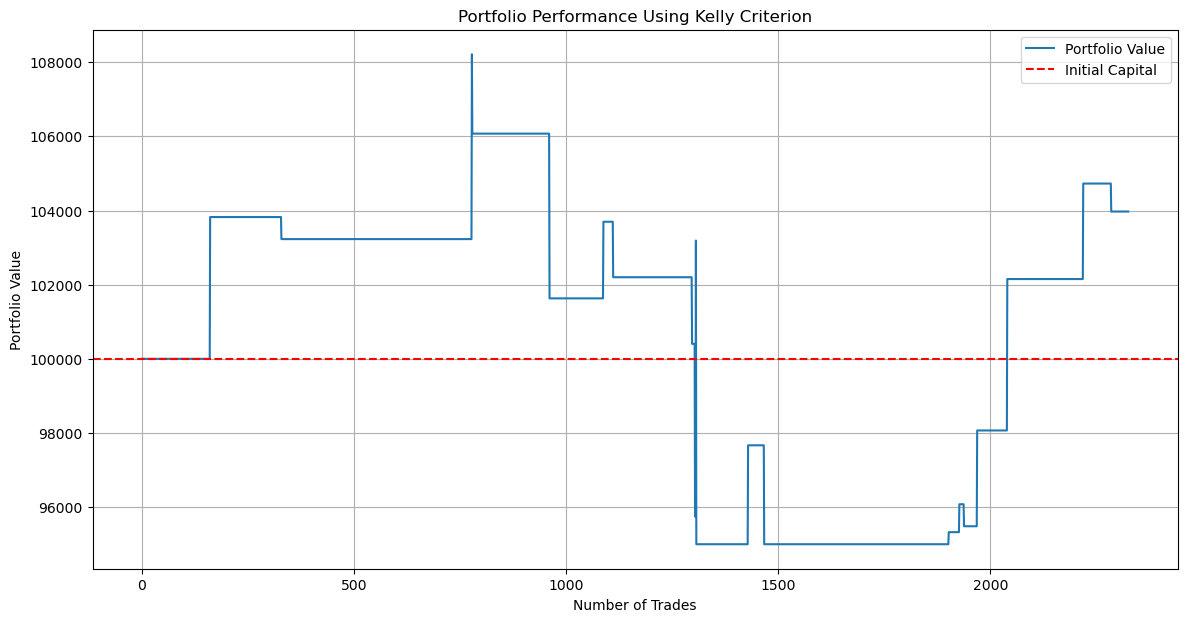

In [4]:

import matplotlib.pyplot as plt
import stock_analysis as sa
from stock_analysis import backtest_kelly_strategy
import yfinance as yf
import pandas as pd

stock_ticker = 'GOOGL'
start_date = '2015-01-01'
googl = yf.download(stock_ticker, start=start_date)

googl['Daily Return'] = googl['Adj Close'].pct_change()

googl['Trading Signal'] = googl['Daily Return'] <= -0.05

googl['Next Day Return'] = googl['Daily Return'].shift(-1)

# Run the backtest using half-Kelly
initial_capital = 100000  # Starting with $100,000
max_risk = 0.05  # Maximum risk is 5% of the portfolio
risk_per_trade = 0.01  # Starting with risking 1% per trade
kelly_fractional = 0.5  # Using half-Kelly
portfolio_values = backtest_kelly_strategy(googl, initial_capital, max_risk, risk_per_trade, kelly_fractional)

plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, label='Portfolio Value')
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial Capital')
plt.title("Portfolio Performance Using Kelly Criterion")
plt.xlabel("Number of Trades")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()


It seems that the strategy is profitable

#### Tentative Conclusion: 
If the highest gainer on the Nasdaq goes up by more than 30%, maybe you should bet on it going down the next day. Odds are pretty good. 